In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import keras
import os, glob
import sys

sys.path.append('..')
from utilities import downsample_series, waveform_stft, waveform_inverse_stft

In [2]:
%matplotlib inline

In [3]:
# %% Need to specify model_name first
model_path = '../Model_and_datasets_spectrogram'
model_name = 'spectrogram_mask_skip_connection'

# %% load model
model = keras.models.load_model(model_path + f'/{model_name}' + f'/{model_name}_Model.hdf5')

# %% make a directory to hold the realistic waveform results
output_dir = model_path + f'/{model_name}' + '/real_waveforms'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [4]:
def load_waveform_and_spectrogram(waveform_dir, file_name, t_shift):
    with h5py.File(waveform_dir + "/" + file_name, "r") as f:
        time = f["time"][:]
        waveform_BH1 = f["waveforms/BH1"][:]
        waveform_BH2 = f["waveforms/BH2"][:]
        waveform_BHZ = f["waveforms/BHZ"][:]
        
    # down-sample the data to the same sampling rate with the trained model
    waveforms, spectrograms, spectrogram_para = [], [], {}
    f_downsample = 1.0
    dt = 1 / f_downsample
    for waveform in [waveform_BH1, waveform_BH2, waveform_BHZ]:
        _, waveform_cur, _ = downsample_series(time=time, 
                                                   series=waveform, 
                                                   f_downsampe=f_downsample)
        time_new = np.arange(0, 600) + t_shift
        waveform_cur = waveform_cur[time_new]
        
        
        
        # STFT the waveforms
        twin = 30
        toverlap = 11  # chose 11 here to make a better shape of the spectrogram
        win_type = 'hann'

        f, t, Sxx_X = waveform_stft(waveform_cur, 
                                    dt, twin=twin, toverlap=toverlap, 
                                    win_type=win_type, complex=True)
        # set a better shape
        t = t[:-1]
        Sxx_X = Sxx_X[:, :-1]
        
        # extract and scale each part
        X_real = np.real(Sxx_X)
        X_imag = np.imag(Sxx_X)
        

        
        # append the processed waveforms and spectrograms
        waveforms.append(waveform_cur)
        spectrograms.append(X_real)
        spectrograms.append(X_imag)
        
    # store some parameters about the spectrogram    
    spectrogram_para['dt'] = dt
    spectrogram_para['twin'] = twin
    spectrogram_para['win_type'] = win_type
    spectrogram_para['toverlap'] = toverlap
    spectrogram_para['t'] = t
    spectrogram_para['f'] = f
    
    waveforms = np.array(waveforms)
    spectrograms = np.array(spectrograms)
    
    return time_new, waveforms, spectrograms, spectrogram_para

In [71]:
def denoise_waveforms(spectrograms, spectrogram_para):
    mean_spectrogram, std_spectrogram = [], []

    for i in range(spectrograms.shape[0]):
        mean_temp, std_temp = np.mean(spectrograms[i, :, :]), np.std(spectrograms[i, :, :])
        spectrograms[i, :, :] = (spectrograms[i, :, :] - mean_temp) / std_temp

        # Keep the mean and std
        mean_spectrogram.append(mean_temp)
        std_spectrogram.append(std_temp)

    # Adjust the dimension of spectrogram input
    spectrograms = spectrograms[np.newaxis, :, :, :]
    spectrograms = np.moveaxis(spectrograms, 1, -1)
    
    # predict the masks based on the spectrograms
    mask_predicted = model.predict(spectrograms)
    
    mask_predicted = mask_predicted * 3 # scaled back to [0, 1]
    
    # Squeeze the spectrograms and masks
    spectrograms = np.squeeze(spectrograms)
    mask_predicted = np.squeeze(mask_predicted)
    
    # reconstruct the waveforms
    waveform_predict = []
    for i in range(3):
        real_part = (spectrograms[:, :, 2*i] * std_spectrogram[2*i] + mean_spectrogram[2*i]) * mask_predicted[:, :, 2*i]
        imag_part = (spectrograms[:, :, 2*i+1] * std_spectrogram[2*i+1] + mean_spectrogram[2*i+1]) * mask_predicted[:, :, 2*i] 

        Sxx_Y_predict = real_part + imag_part * 1j

        time_predict, waveform_temp = waveform_inverse_stft(Sxx_Y_predict, 
                                              dt=spectrogram_para['dt'], 
                                              twin=spectrogram_para['twin'], 
                                              toverlap=spectrogram_para['toverlap'])
        waveform_predict.append(waveform_temp)
    
    waveform_predict = np.array(waveform_predict)
    
    return time_predict, waveform_predict

In [83]:
# load the waveforms
waveform_dir = "../waveforms/events_data_processed"
waveform_files = np.array(os.listdir(waveform_dir))

In [84]:
waveform_files

array(['IU.XMAS.M6.5.20210401-095637.hdf5',
       'IU.XMAS.M6.4.20190306-154614.hdf5',
       'IU.XMAS.M7.0.20210121-122304.hdf5',
       'IU.XMAS.M6.4.20200109-083808.hdf5',
       'IU.XMAS.M6.4.20191016-113705.hdf5',
       'IU.XMAS.M7.8.20200722-061244.hdf5',
       'IU.XMAS.M6.0.20191114-211254.hdf5',
       'IU.XMAS.M6.1.20200128-215516.hdf5',
       'IU.XMAS.M6.1.20200126-063155.hdf5',
       'IU.XMAS.M6.1.20190422-091111.hdf5',
       'IU.XMAS.M6.0.20200416-080437.hdf5',
       'IU.XMAS.M6.3.20200127-050201.hdf5',
       'IU.XMAS.M8.1.20210304-192833.hdf5',
       'IU.XMAS.M6.0.20191224-190352.hdf5',
       'IU.XMAS.M6.3.20191120-042705.hdf5',
       'IU.XMAS.M6.3.20190519-012329.hdf5',
       'IU.XMAS.M6.0.20200129-134949.hdf5',
       'IU.XMAS.M6.1.20200722-061618.hdf5',
       'IU.XMAS.M6.1.20210304-231300.hdf5',
       'IU.XMAS.M6.2.20200123-055302.hdf5',
       'IU.XMAS.M6.7.20210203-052343.hdf5',
       'IU.XMAS.M6.0.20200118-163814.hdf5',
       'IU.XMAS.M6.6.20200818-00

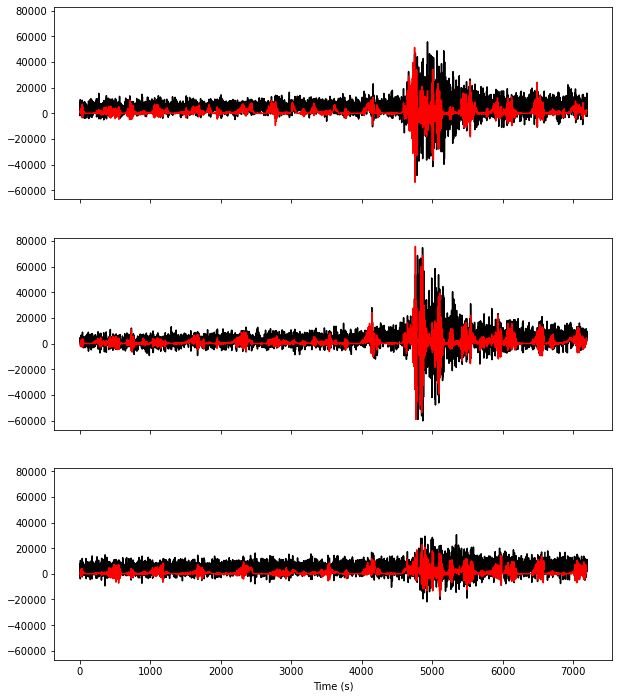

In [89]:
file_name = "IU.XMAS.M6.7.20210203-052343.hdf5"
step = 600
plt.close('all')
_, ax = plt.subplots(3, 1, sharex=True, sharey=True, num=1, figsize=(10, 12))
for t_shift in np.arange(0, 6900, step):
    time_new, waveforms, spectrograms, spectrogram_para = load_waveform_and_spectrogram(waveform_dir, file_name, t_shift)
    time_predict, waveform_predict = denoise_waveforms(spectrograms, spectrogram_para)
    time_predict = time_predict + t_shift
    
    for i, axi in enumerate(ax):
        axi.plot(time_new, waveforms[i, :], '-k', zorder=1)
        axi.plot(time_predict, waveform_predict[i, :], '-r', zorder=10)
    if i == 2:
        axi.set_xlabel('Time (s)')
#axi.set_xlim(3500, 5000)